El servicio de venta de autos usados Rusty Bargain está desarrollando una aplicación para atraer nuevos clientes. Gracias a esa app, puedes averiguar rápidamente el valor de mercado de tu coche. Tienes acceso al historial: especificaciones técnicas, versiones de equipamiento y precios. Tienes que crear un modelo que determine el valor de mercado.
A Rusty Bargain le interesa:
- la calidad de la predicción;
- la velocidad de la predicción;
- el tiempo requerido para el entrenamiento

In [1]:
#Importamos librerías
import pandas as pd
import numpy as np
import math
import seaborn as sns
import lightgbm as lgb
import time
import matplotlib.pyplot as plt
import sklearn.linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

## Preparación de datos

In [2]:
df = pd.read_csv("/datasets/car_data.csv")
print(df.shape)
print()
df.sample(10)

(354369, 16)



,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
117039,31/03/2016 12:25,2650,wagon,2006,manual,101,astra,150000,5,gasoline,opel,no,31/03/2016 00:00,0,61389,31/03/2016 13:26
142977,15/03/2016 21:49,7500,other,2006,manual,150,golf,150000,11,petrol,volkswagen,no,15/03/2016 00:00,0,57368,07/04/2016 06:16
263054,04/04/2016 22:50,1350,small,2002,manual,60,ka,150000,8,petrol,ford,NaN,04/04/2016 00:00,0,20357,07/04/2016 02:17
178318,24/03/2016 20:51,300,coupe,1997,manual,102,3er,150000,10,petrol,bmw,yes,24/03/2016 00:00,0,66359,03/04/2016 15:45
262227,16/03/2016 17:48,3400,small,2007,manual,67,matiz,40000,9,petrol,chevrolet,NaN,16/03/2016 00:00,0,87437,27/03/2016 06:16
293329,16/03/2016 23:48,5999,coupe,1979,manual,110,scirocco,150000,9,petrol,volkswagen,no,16/03/2016 00:00,0,71229,05/04/2016 19:46
228023,31/03/2016 22:36,600,small,1999,manual,0,fortwo,100000,12,petrol,smart,NaN,31/03/2016 00:00,0,21029,01/04/2016 02:42
141406,18/03/2016 09:48,2700,convertible,1995,auto,90,golf,100000,11,petrol,volkswagen,NaN,18/03/2016 00:00,0,51643,26/03/2016 11:15
231210,09/03/2016 20:57,1700,wagon,2007,manual,102,astra,150000,12,gasoline,opel,yes,09/03/2016 00:00,0,24955,12/03/2016 22:46
256855,04/04/2016 16:38,12499,wagon,2007,auto,231,5er,150000,7,gasoline,bmw,no,04/04/2016 00:00,0,89155,06/04/2016 18:16


In [4]:
#Hacemos un análisis exploratorio de los datos
display(df.describe())
print()
#Buscamos valores faltantes
print("Valores faltantes")
print(df.isna().sum())
print()
#Buscamos valores duplicados
print("Filas duplicadas")
print(df.duplicated().sum())

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000



Valores faltantes
DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Mileage                  0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Filas duplicadas
262


In [5]:
#Revisamos ejemplos de los valores duplicados
print("Ejemplos de valores duplicados")
print(df[df.duplicated()].head())
print()
#Revisamos ejemplos de los valores faltantes
print("Ejemplos de valores duplicados")
print(df[df.isna()].head())

Ejemplos de valores duplicados
            DateCrawled  Price  VehicleType  RegistrationYear Gearbox  Power  \
14266  21/03/2016 19:06   5999        small              2009  manual     80   
27568  23/03/2016 10:38  12200          bus              2011  manual    125   
31599  03/04/2016 20:41   4950        wagon              2003    auto    170   
33138  07/03/2016 20:45  10900  convertible              2005    auto    163   
43656  13/03/2016 20:48   4200        sedan              2003  manual    105   

          Model  Mileage  RegistrationMonth  FuelType          Brand  \
14266      polo   125000                  5    petrol     volkswagen   
27568    zafira    40000                 10  gasoline           opel   
31599  e_klasse   150000                  4  gasoline  mercedes_benz   
33138       clk   125000                  5    petrol  mercedes_benz   
43656      golf   150000                 10  gasoline     volkswagen   

      NotRepaired       DateCreated  NumberOfPictures  

In [6]:
cols_nan = ["VehicleType", "Gearbox", "Model", "FuelType", "NotRepaired"]
df[cols_nan].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   VehicleType  316879 non-null  object
 1   Gearbox      334536 non-null  object
 2   Model        334664 non-null  object
 3   FuelType     321474 non-null  object
 4   NotRepaired  283215 non-null  object
dtypes: object(5)
memory usage: 13.5+ MB


In [7]:
#Eliminamos las filas de valores faltantes y duplicados 
df_clean = df.drop_duplicates().dropna().reset_index(drop=True)

Revisamos y limpiamos los datos, se observó que las variables con valores Nan eran de tipo object en su mayoría.

Se tienen df con observaciones suficientes pese a que se eliminaron varias filas.

También se procedió a eliminar las columnas que no aportan información para calcular la variable objetivo "Price" para reducir la complejidad computacional.

In [8]:
# Eliminar columnas irrelevantes para reducir la complejidad computacional 
cols_to_drop = ['DateCrawled', 'DateCreated', 'LastSeen', 'PostalCode', 'NumberOfPictures', 'RegistrationMonth']
df_clean = df_clean.drop(columns=cols_to_drop)

In [9]:
display(df_clean.describe())

,Price,RegistrationYear,Power,Mileage
count,245567.000000,245567.000000,245567.000000,245567.000000
mean,5125.680959,2002.918287,119.971796,127297.112397
std,4718.468928,6.164689,139.448062,37079.536493
min,0.000000,1910.000000,0.000000,5000.000000
25%,1499.000000,1999.000000,75.000000,125000.000000
50%,3500.000000,2003.000000,110.000000,150000.000000
75%,7500.000000,2007.000000,150.000000,150000.000000
max,20000.000000,2018.000000,20000.000000,150000.000000


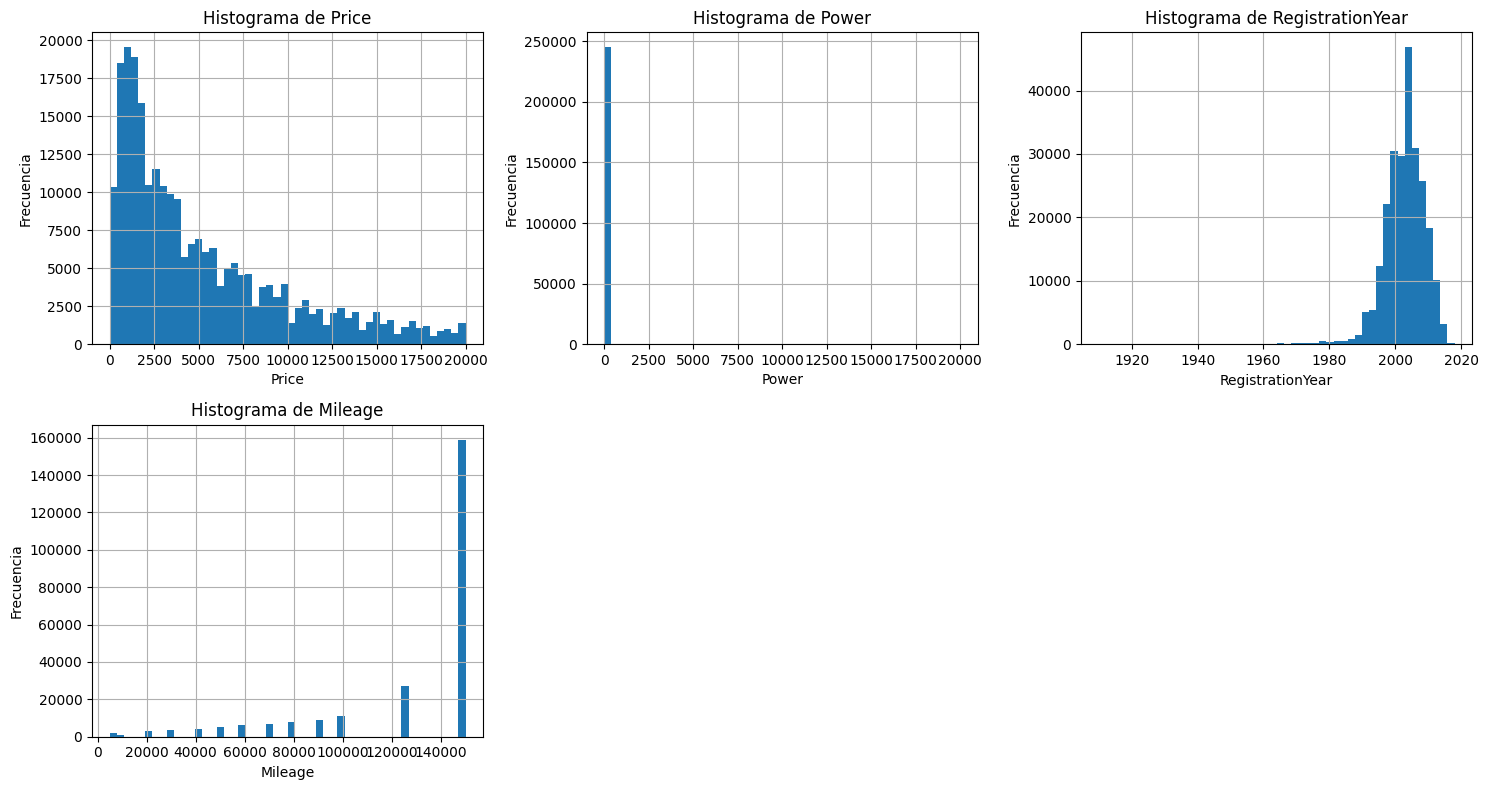

In [10]:
#Revisamos como se distribuyen los datos numericos en df_clean
num_cols = ['Price', 'Power', 'RegistrationYear', 'Mileage']
#Hacemos histogrrama 
n = len(num_cols)
n_cols = 3  # columnas por fila
n_rows = math.ceil(n / n_cols)

plt.figure(figsize=(n_cols * 5, n_rows * 4))

for i, col in enumerate(num_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    df_clean[col].hist(bins=50)
    plt.title(f'Histograma de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

In [11]:
#Una vez analizada la distribución de las variables cuantitativas, se procederá a seleccionar las filas que posean un rango de variables verdadero para todas las variables
# Price (se eliminaron los valores muy bajos como 0 y se comenzó desde un precio bajo para un automovil)
df_clean = df_clean[(df_clean['Price'] >= 1000) & (df_clean['Price'] <= 20000)]

# RegistrationYear (se eliminaron valores irreales como 1000)
df_clean = df_clean[(df_clean['RegistrationYear'] >= 1930) & (df_clean['RegistrationYear'] <= 2024)]

# Power (se colocó un limite superior razonable tomando en cuenta modelos de alta potencia)
df_clean = df_clean[(df_clean['Power'] > 0) & (df_clean['Power'] < 1000)]

#Los valores de la variable Mileage son rezonables

In [12]:
#Información de los df con los que se trabajará
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 198618 entries, 0 to 245566
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             198618 non-null  int64 
 1   VehicleType       198618 non-null  object
 2   RegistrationYear  198618 non-null  int64 
 3   Gearbox           198618 non-null  object
 4   Power             198618 non-null  int64 
 5   Model             198618 non-null  object
 6   Mileage           198618 non-null  int64 
 7   FuelType          198618 non-null  object
 8   Brand             198618 non-null  object
 9   NotRepaired       198618 non-null  object
dtypes: int64(4), object(6)
memory usage: 16.7+ MB


<div class="alert alert-block alert-success"> <b>Comentario del revisor</b> <a class="tocSkip"></a><br> <b>Éxito</b> - Excelente inicio. Has realizado una limpieza de datos detallada, eliminando duplicados, valores faltantes y filtrando registros irreales de manera fundamentada. Además, redujiste la complejidad eliminando columnas irrelevantes y analizaste visualmente la distribución de las variables. Este enfoque metódico fortalecerá mucho tu modelado. </div>


## Entrenamiento del modelo 

In [13]:
Y = df_clean['Price']
X = df_clean.drop(columns=['Price'])

In [14]:
#Codificamos variables categoricas usando Label encoding o OHE según sean las necesidades del modelo
#Label encoding
X_label = X.copy()
for col in X_label.select_dtypes(include='object').columns:
    X_label[col] = LabelEncoder().fit_transform(X_label[col])
#OHE
X_ohe = pd.get_dummies(X, drop_first=True)

In [15]:
#Dividimos datos
def split_data(X_dict, Y, test_size=.25, random_state=1234):
    splits = {}
    for name, X in X_dict.items():
        x_train, x_test, y_train_split, y_test_split = train_test_split(X, Y, test_size=test_size, random_state=random_state)
        splits[name] = (x_train, x_test, y_train_split, y_test_split)
    return splits

In [16]:
# Diccionario con las versiones de X 
X_versions = {
    "label": X_label,
    "ohe": X_ohe,
    "original": X
}

# Dividimos
splits = split_data(X_versions, Y)

# Acceso a los datos
X_train_label, X_test_label, Y_train_label, Y_test_label = splits["label"]
X_train_ohe, X_test_ohe, Y_train_ohe, Y_test_ohe = splits["ohe"]
X_train, X_test, Y_train, Y_test = splits["original"]

**Regresión Lineal**

In [17]:
#Normalizamos datos para tener mejores resultados
scaler = StandardScaler()
X_train_ohe_scaled = scaler.fit_transform(X_train_ohe)  
X_test_ohe_scaled = scaler.transform(X_test_ohe)  

In [18]:

#Entrenamos modelo
start_linreg_train = time.time()
linreg=LinearRegression().fit(X_train_ohe_scaled, Y_train_ohe)
end_linreg_train = time.time()

#Hacemos las predicciones
start_linreg_pred = time.time()
Y_pred_linreg=linreg.predict(X_test_ohe_scaled)
end_linreg_pred = time.time()

#Análisi de resultados de tiempo
linreg_traintime = end_linreg_train - start_linreg_train
linreg_predtime = end_linreg_pred - start_linreg_pred

#Evaluamos el Error Cuadratico Medio o RMSE
rmse_linreg = np.sqrt(mean_squared_error(Y_test_ohe, Y_pred_linreg))

#Evaluamos r2
linreg_r2 = r2_score(Y_test_ohe, Y_pred_linreg)

print(f"Tiempo de entrenamiento Linear Regression: {linreg_traintime:.2f} s")
print(f"Tiempo de predicción Linear Regression: {linreg_predtime:.4f} s")
print(f"RMSE del modelo Linear Regression: {rmse_linreg:.2f}")
print(f"R² Linear Regression: {linreg_r2:.3f}")

Tiempo de entrenamiento Linear Regression: 16.59 s
Tiempo de predicción Linear Regression: 0.0911 s
RMSE del modelo Linear Regression: 2587.90
R² Linear Regression: 0.691


**Random Forest**

In [20]:
#Entrenamos modelo seleccionando la combinación de mejores parametros con Validación Cruzada
start_rf_train = time.time()
rf = RandomForestRegressor(random_state=1234)
params = {"n_estimators": [50, 100], "max_depth": [10, 20]}
grid_search = GridSearchCV(rf, params, cv=5, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train_label, Y_train_label)
best_rf = grid_search.best_estimator_
print(f"Mejores parámetros: {grid_search.best_params_}")
end_rf_train = time.time()
print()
#Hacemos las predicciones
start_rf_pred = time.time()
Y_pred_rf = best_rf.predict(X_test_label)
end_rf_pred = time.time()
print()

#Análisi de resultados de tiempo
rf_traintime = end_rf_train - start_rf_train
rf_predtime = end_rf_pred - start_rf_pred

#Evaluamos el Error Cuadratico Medio o RMSE
rmse_rf=np.sqrt(mean_squared_error(Y_test_label, Y_pred_rf))

#Evaluamos r2
rf_r2 = r2_score(Y_test_label, Y_pred_rf)

print(f"Tiempo de entrenamiento Random Forest: {rf_traintime:.2f} s")
print(f"Tiempo de predicción Random Forest: {rf_predtime:.4f} s")
print(f"RMSE del modelo Random Forest: {rmse_rf:.2f}")
print(f"R² Random Forest: {rf_r2:.3f}")

Mejores parámetros: {'max_depth': 20, 'n_estimators': 100}


Tiempo de entrenamiento Random Forest: 244.07 s
Tiempo de predicción Random Forest: 1.1835 s
RMSE del modelo Random Forest: 1616.14
R² Random Forest: 0.880


**LightGBM**

In [21]:
#LightGBM requiere que se le indique cuales son las columnas categóricas
cat_cols = X.select_dtypes(include='object').columns.tolist()
print("Columnas categóricas codificadas:", cat_cols)

Columnas categóricas codificadas: ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']


In [22]:
#Entrenamos modelo
start_lgb_train = time.time()
lgb_model = lgb.LGBMRegressor(learning_rate=0.1, random_state=1234)
params_lgb = {'num_leaves': [31, 50], 'n_estimators': [100, 200]}
grid_search_lgb = GridSearchCV(estimator=lgb_model, param_grid=params_lgb, cv=5, scoring='neg_root_mean_squared_error', verbose=0)
grid_search_lgb.fit(X_train_label, Y_train_label, categorical_feature=cat_cols) #A LGBM se le debe indicar cuales son variables categoricas
best_lgb = grid_search_lgb.best_estimator_
print(f"Mejores parámetros LightGBM: {grid_search_lgb.best_params_}")
end_lgb_train = time.time()

#Hacemos las predicciones
start_lgb_pred = time.time()
Y_pred_lgb = best_lgb.predict(X_test_label)
end_lgb_pred = time.time()

#Análisi de resultados de tiempo
lgb_traintime = end_lgb_train - start_lgb_train
lgb_predtime = end_lgb_pred - start_lgb_pred

#Evaluamos el Error Cuadratico Medio o RMSE
rmse_lgb=np.sqrt(mean_squared_error(Y_test_label, Y_pred_lgb))

#Evaluamos r2
lgb_r2 = r2_score(Y_test_label, Y_pred_lgb)

print(f"Tiempo de entrenamiento LightGBM: {lgb_traintime:.2f} s")
print(f"Tiempo de predicción LightGBM: {lgb_predtime:.4f} s")
print(f"RMSE del modelo LightGBM: {rmse_lgb:.2f}")
print(f"R² LightGBM: {lgb_r2:.3f}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/.venv/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/.venv/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/.venv/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/.venv/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/.venv/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/.venv/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/.ve

Mejores parámetros LightGBM: {'n_estimators': 200, 'num_leaves': 50}
Tiempo de entrenamiento LightGBM: 53.14 s
Tiempo de predicción LightGBM: 0.4095 s
RMSE del modelo LightGBM: 1574.02
R² LightGBM: 0.886


**CatBoost**

In [24]:
#Entrenamos modelo
start_cb_train = time.time()
cb_model = CatBoostRegressor(learning_rate=0.1, random_seed=1234, verbose=0)
params_cb = {'depth': [5, 10], 'iterations': [100, 150]}
grid_search_cb = GridSearchCV(estimator=cb_model, param_grid=params_cb, cv=5, scoring='neg_root_mean_squared_error')
grid_search_cb.fit(X_train, Y_train, cat_features=cat_cols) 
best_cb = grid_search_cb.best_estimator_
print(f"Mejores parámetros CatBoost: {grid_search_cb.best_params_}")
end_cb_train = time.time()

#Hacemos las predicciones
start_cb_pred = time.time()
Y_pred_cb = best_cb.predict(X_test)
end_cb_pred = time.time()

#Análisi de resultados de tiempo
cb_traintime = end_cb_train - start_cb_train
cb_predtime = end_cb_pred - start_cb_pred

#Evaluamos el Error Cuadratico Medio o RMSE
rmse_cb=np.sqrt(mean_squared_error(Y_test, Y_pred_cb))

#Evaluamos r2
cb_r2 = r2_score(Y_test, Y_pred_cb)

print(f"Tiempo de entrenamiento CatBoost: {cb_traintime:.2f} s")
print(f"Tiempo de predicción CatBoost: {cb_predtime:.4f} s")
print(f"RMSE del modelo CatBoost: {rmse_cb:.2f}")
print(f"R² CatBoost: {cb_r2:.3f}")

Mejores parámetros CatBoost: {'depth': 10, 'iterations': 150}
Tiempo de entrenamiento CatBoost: 56.85 s
Tiempo de predicción CatBoost: 0.0506 s
RMSE del modelo CatBoost: 1668.18
R² CatBoost: 0.872


<div class="alert alert-block alert-success"> <b>Comentario del revisor</b> <a class="tocSkip"></a><br> <b>Éxito</b> - Muy bien logrado el entrenamiento y evaluación de modelos. Has aplicado una estrategia completa que incluye regresión lineal como base comparativa, validación cruzada y optimización de hiperparámetros para modelos avanzados, y además presentaste un análisis comparativo claro y bien argumentado. Gran implementación. </div>


## Análisis del modelo

In [30]:
results = []

results.append({
    "Modelo": "Linear Regression",
    "RMSE": rmse_linreg,
    "Tiempo_entrenamiento (s)": linreg_traintime,
    "Tiempo_predicción (s)": linreg_predtime,
    "R²": linreg_r2})

results.append({
    "Modelo": "Random Forest",
    "RMSE": rmse_rf,
    "Tiempo_entrenamiento (s)": rf_traintime,
    "Tiempo_predicción (s)": rf_predtime,
    "R²": rf_r2})

results.append({
    "Modelo": "LightGBM",
    "RMSE": rmse_lgb,
    "Tiempo_entrenamiento (s)": lgb_traintime,
    "Tiempo_predicción (s)": lgb_predtime,
    "R²": lgb_r2})

results.append({
    "Modelo": "CatBoost",
    "RMSE": rmse_cb,
    "Tiempo_entrenamiento (s)": cb_traintime,
    "Tiempo_predicción (s)": cb_predtime,
    "R²": cb_r2})

# Convertimos a DataFrame para presentar los resultados finales
df_results = pd.DataFrame(results)
display(df_results.sort_values("RMSE"))


,Modelo,RMSE,Tiempo_entrenamiento (s),Tiempo_predicción (s),R²
2,LightGBM,1574.015747,53.137177,0.409485,0.885735
1,Random Forest,1616.139421,244.070040,1.183516,0.879537
3,CatBoost,1668.175373,56.847710,0.050601,0.871655
0,Linear Regression,2587.895756,4.312903,0.085059,0.691121


<div class="alert alert-block alert-success"> <b>Comentario del revisor</b> <a class="tocSkip"></a><br> <b>Éxito</b> - Excelente resumen comparativo. La tabla de resultados está bien estructurada y permite evaluar con claridad el equilibrio entre precisión, tiempos de entrenamiento y predicción. Esta síntesis refuerza tus conclusiones y facilita la elección del modelo óptimo. </div>


# Conclusiones

Se probaron cuatro modelos para predecir el precio de vehículos: **Linear Regression**, **Random Forest**, **LightGBM** y **CatBoost**.

- **Linear Regression** se utilizó como modelo base (prueba de cordura).  
  Al ser un modelo simple y sin necesidad de ajuste de hiperparámetros, logró el **menor tiempo de entrenamiento** y **predicción rápida**. Sin embargo, obtuvo el **peor desempeño en predicción**, con un **RMSE de 2587.90** y **R² de 0.691**.

- **Random Forest** mejoró la calidad de la predicción (**RMSE de 1616.14**, **R² de 0.88**), pero tuvo el **mayor tiempo de entrenamiento**  y la **predicción más lenta**, lo que lo hace menos eficiente computacionalmente.

- **LightGBM** y **CatBoost** fueron los modelos más equilibrados en cuanto a calidad de predicción y eficiencia:

  - **LightGBM** obtuvo el **mejor RMSE (1574.02)** y el **mayor R² (0.886)**.  Además, tuvo un tiempo de entrenamiento razonable y un tiempo de predicción aceptable.

  - **CatBoost** también ofreció una precisión competitiva (**RMSE de 1668.18**, **R² de 0.872**)  
    y se destacó por su velocidad de predicción, ideal para aplicaciones en tiempo real.

---

## Recomendación

- Para obtener la **mejor calidad de predicción con buen rendimiento computacional**, se recomienda **LightGBM**.
- Si la **velocidad de predicción es prioritaria** (por ejemplo, en entornos en tiempo real), **CatBoost** es una excelente opción.

<div class="alert alert-block alert-success"> <b>Comentario del revisor</b> <a class="tocSkip"></a><br> <b>Éxito</b> - Tu conclusión es clara, bien argumentada y alineada con los resultados obtenidos. Has destacado de forma precisa las fortalezas y limitaciones de cada modelo, y tu recomendación final refleja un análisis reflexivo que considera tanto la precisión como la eficiencia. Muy buen cierre analítico. </div>


# Lista de control

Escribe 'x' para verificar. Luego presiona Shift+Enter

- [x]  Jupyter Notebook está abierto
- [ ]  El código no tiene errores- [ ]  Las celdas con el código han sido colocadas en orden de ejecución- [ ]  Los datos han sido descargados y preparados- [ ]  Los modelos han sido entrenados
- [ ]  Se realizó el análisis de velocidad y calidad de los modelos

## Comentario general del revisor 



<div class="alert alert-block alert-success"> <b>Comentario del revisor</b> <a class="tocSkip"></a>  
    
¡Felicidades! Tu proyecto está <b>aprobado</b>. Has demostrado un excelente dominio del flujo de trabajo en machine learning, desde la limpieza rigurosa de los datos hasta la evaluación comparativa de distintos modelos. Tu análisis es claro, completo y orientado a la toma de decisiones.  
A continuación, destaco los puntos positivos:

#### Puntos Positivos:

* **Procesamiento de datos:** Realizaste una limpieza minuciosa y fundamentada, eliminando datos irreales y columnas innecesarias sin comprometer la calidad del conjunto.
* **Visualización y análisis gráfico:** Los histogramas fueron útiles para justificar los umbrales de filtrado de outliers y reforzar tus decisiones.
* **Ingeniería de características:** Aplicaste codificación categórica con criterio, diferenciando entre Label Encoding y One-Hot según el modelo.
* **Comparación de modelos:** Evaluaste de forma equilibrada regresión lineal, Random Forest, LightGBM y CatBoost, destacando métricas clave como RMSE y R², además del rendimiento computacional.

Tu proyecto demuestra una comprensión sólida del problema y una capacidad analítica destacable. ¡Vas por un excelente camino! </div>
